In [25]:
# To Do:
# experiment with other MONAI classifiers
# change the mask dimension to the output of the segmentation model
# see if theres a better way to use the segmentation map in the model
# hand crafted features e.g. bounding box fuzziness, width of mask, convex hull difference from mask to work out border irregularity etc
# add augmentation 
# patch based training
#!pip install ray[tune]

In [1]:
import matplotlib.pyplot as plt
import numpy as np
from scipy.ndimage import gaussian_filter

# Create an original shape (a simple circle)
mask = train_dataset[88][3].squeeze().numpy()

# Apply Gaussian smoothing to the shape
sigma = 12  # Standard deviation for Gaussian kernel
smoothed_mask = gaussian_filter(mask, sigma=sigma)
smoothed_mask = (smoothed_mask >= 0.5).astype(np.uint8)

# Calculate the intersection and union between the original and irregular ovals
intersection = np.logical_and(mask, smoothed_mask).astype(float)
union = np.logical_or(mask, smoothed_mask).astype(float)

# Plot the more irregular oval and its Gaussian smoothed version, as well as intersection and union
fig, axs = plt.subplots(1, 2, figsize=(10, 5))

# More irregular oval shape
axs[0].imshow(mask, cmap='gray')
axs[0].set_title("Segmentation Mask")
axs[0].axis('off')

# Gaussian smoothed more irregular oval shape
axs[1].imshow(smoothed_mask, cmap='gray')
axs[1].set_title(f"Gaussian Smoothed Mask (sigma={sigma})")
axs[1].axis('off')

# # Intersection of original and irregular oval
# axs[1, 0].imshow(intersection, cmap='gray')
# axs[1, 0].set_title("Intersection of Original and Smoothed Mask")
# axs[1, 0].axis('off')
# 
# # Union of original and irregular oval
# axs[1, 1].imshow(union, cmap='gray')
# axs[1, 1].set_title("Union of Original and Smoothed Mask")
# axs[1, 1].axis('off')

# Display the plots
plt.show()



NameError: name 'train_dataset' is not defined

In [3]:
}! git clone https://github.com/oliverjm1/mycetoma_segmentation.git


Cloning into 'mycetoma_segmentation'...


In [2]:
import os
import numpy as np
import torch
import torch.nn.functional as F
import torchvision.transforms.functional as F2
import torchvision.transforms.v2 as transforms
from torch.utils.data import DataLoader, Dataset
import torch.nn as nn
import matplotlib.pyplot as plt
import pandas as pd
import random
import glob
from collections import Counter
from PIL import Image
from sklearn.metrics import accuracy_score, roc_auc_score, confusion_matrix, roc_curve, auc
from sklearn.calibration import calibration_curve
from monai.networks.nets import DenseNet169 #, HighResNet, EfficientNet, ResNet
from ray import tune
from ray.tune.schedulers import ASHAScheduler # taken from link https://www.geeksforgeeks.org/hyperparameter-tuning-with-ray-tune-in-pytorch/
from ray.tune.search.hyperopt import HyperOptSearch


device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
DATA_DIR = r"C:\Users\mm17b2k.DS\DataspellProjects\MICCAI\Mycetoma Dataset"

# Get the paths
train_paths = np.array(['.'.join(i.split('.')) for i in glob.glob(f'{DATA_DIR}/training_dataset/**/*')])
val_paths = np.array(['.'.join(i.split('.')) for i in glob.glob(f'{DATA_DIR}/validation_dataset/**/*')])

#post processing binary 
train_seg_paths_bin = np.array(['.'.join(i.split('.')) for i in glob.glob(f'{DATA_DIR}/binary postprocessed/corrected_masks_and_augmented_postproc_training/**/*')])
val_seg_paths_bin = np.array(['.'.join(i.split('.')) for i in glob.glob(f'{DATA_DIR}/binary postprocessed/corrected_masks_and_augmented_postproc_validation/**/*')])


#post processing logit
train_seg_paths_log = np.array(['.'.join(i.split('.')) for i in glob.glob(f'{DATA_DIR}/logit output/corrected_masks_and_augmented_training/**/*')])
val_seg_paths_log = np.array(['.'.join(i.split('.')) for i in glob.glob(f'{DATA_DIR}/logit output/corrected_masks_and_augmented_validation/**/*')])

# multitask binary
train_seg_paths_multibin = np.array(['.'.join(i.split('.')) for i in glob.glob(f'{DATA_DIR}/multitask/binary postprocessed/multitask_postproc_training/**/*')])
val_seg_paths_multibin = np.array(['.'.join(i.split('.')) for i in glob.glob(f'{DATA_DIR}/multitask/binary postprocessed/multitask_postproc_validation/**/*')])

# multitask logit
train_seg_paths_multilog = np.array(['.'.join(i.split('.')) for i in glob.glob(f'{DATA_DIR}/multitask/logit output/multitask_training/**/*')])
val_seg_paths_multilog = np.array(['.'.join(i.split('.')) for i in glob.glob(f'{DATA_DIR}/multitask/logit output/multitask_validation/**/*')])


# remove any with mask in it
train_img_paths = train_paths[[not 'mask' in i for i in train_paths]]
val_img_paths = val_paths[[not 'mask' in i for i in val_paths]]
img_paths = [train_img_paths, val_img_paths]

def format_file_paths(paths, img_paths):
    file_paths = []
    patient = []
    for file in img_paths:
        patient.append(file)
        matched = False
        #file_start = '.'.join(file.split('.')[:-1])
        file_end = file.split("\\")[-1].split('.')[0]
        for file2 in paths:
            if 'mask' in file2:
                #file_start2 = '.'.join(file2.split('.')[:-1])[:-5]
                file_end2 = '_'.join(file2.split("\\")[-1].split('.')[0].split('_')[0:2])
                if file_end == file_end2:
                    patient.append(file2)
                    file_paths.append(patient)
                    patient = []
                    matched = True
        if matched == False:
            print(f"Could not find mask for {file_end}")
    return file_paths

train_paths = format_file_paths(train_seg_paths_multibin, train_img_paths)
val_paths = format_file_paths(val_seg_paths_multibin, val_img_paths)



print(f"Train length: {len(train_paths)}")
print(f"Val length: {len(val_paths)}")


def clip_and_norm(image, upper_bound):
    # Clip intensity values
    image = np.clip(image, 0, upper_bound)

    # Normalize the image to the range [0, 1]
    norm = (image - 0) / (upper_bound - 0)
    # minmax scaling
    #norm = (image - np.min(image)) / (np.max(image) - np.min(image))
    
    return norm

Train length: 593
Val length: 91


In [50]:
# MAKE DATASET CLASS

# Define the 3D Dataset class
# Image and mask both need same transforms to be applied, so DO NOT USE RANDOM TRANSFORMS
# - use e.g. transforms.functional.hflip which has no randomness.
class MycetomaDataset(Dataset):
    def __init__(self, paths, data_dir, hand_crafted_features_df, mask_channel=False, transform=None, transform_chance=0.5):
        self.paths = paths
        self.data_dir = data_dir
        self.transform = transform
        self.transform_chance = transform_chance
        self.mask_channel = mask_channel
        self.hand_crafted_features_df = hand_crafted_features_df

    def __len__(self):
        return len(self.paths)

    def __getitem__(self, index):
        image_path = self.paths[index][0]
        mask_path = self.paths[index][1]

        # Load the image and mask
        image = np.asarray(Image.open(image_path))
        mask = np.asarray(Image.open(mask_path))
        if 'BM' in image_path:
            label = 0
        if 'FM' in image_path:
            label = 1

        # Check image and mask size
        assert image.shape == (600, 800, 3), "Image size must be (600, 800, 3)"

        # if mask more than one channel, turn to 2d by taking first channel
        if len(mask.shape) > 2:
            mask = mask[..., 0]

        # normalise image
        image = clip_and_norm(image, 255)
        

        # clip mask
        # assert mask.max() == 1, "Mask must be binary"

        # turn to torch, permute image to move channel to front, and return
        image = torch.from_numpy(image).float().permute(2,0,1)
        mask = torch.from_numpy(mask).float().unsqueeze(0)
        
        if self.transform != None:
            transform1 = transforms.Compose([
                transforms.RandomHorizontalFlip(p=0.8),
                transforms.RandomVerticalFlip(p=0.8),
            ])
            transform2 = transforms.Compose([
                transforms.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2, hue=0.02)
            ])
            
            image = transform1(image)
            image = transform2(image)
            
        # save image as png
        print(image.shape, index)
        # save torch tensor as png image
        tensor = image.permute(1, 2, 0).numpy()

        # Clip the values to be between 0 and 1, then scale to [0, 255]
        tensor = np.clip(tensor, 0, 1)
        tensor = (tensor * 255).astype(np.uint8)
        
        # Convert the numpy array to a PIL Image and save it
        image = Image.fromarray(tensor)
        image.save(f'image_non_{index}.png')
                
        if self.mask_channel:
            image = torch.cat((image, mask), dim=0)

        # Get hand-crafted features
        hand_crafted_features = self.hand_crafted_features_df.iloc[index].values
        
        return image, hand_crafted_features, label, mask

hand_crafted_features_df = pd.read_csv('features_normalised.csv')
hand_crafted_features_val_df = pd.read_csv('test_features_normalised.csv')

train_paths = format_file_paths(train_seg_paths_multibin, train_img_paths)
val_paths = format_file_paths(val_seg_paths_multibin, val_img_paths)

train_dataset = MycetomaDataset(train_paths, DATA_DIR, hand_crafted_features_df, mask_channel=False, transform=True)
test_dataset = MycetomaDataset(val_paths, DATA_DIR, hand_crafted_features_val_df,  mask_channel=True)
# MAKE DATALOADER
train_loader = DataLoader(train_dataset, batch_size=10, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=5, shuffle=False)

In [52]:
next(iter(train_loader))

torch.Size([3, 600, 800]) 0
torch.Size([3, 600, 800]) 1
torch.Size([3, 600, 800]) 2
torch.Size([3, 600, 800]) 3
torch.Size([3, 600, 800]) 4
torch.Size([3, 600, 800]) 5
torch.Size([3, 600, 800]) 6
torch.Size([3, 600, 800]) 7
torch.Size([3, 600, 800]) 8
torch.Size([3, 600, 800]) 9


TypeError: default_collate: batch must contain tensors, numpy arrays, numbers, dicts or lists; found <class 'PIL.Image.Image'>

Calculated Perimeter: 286


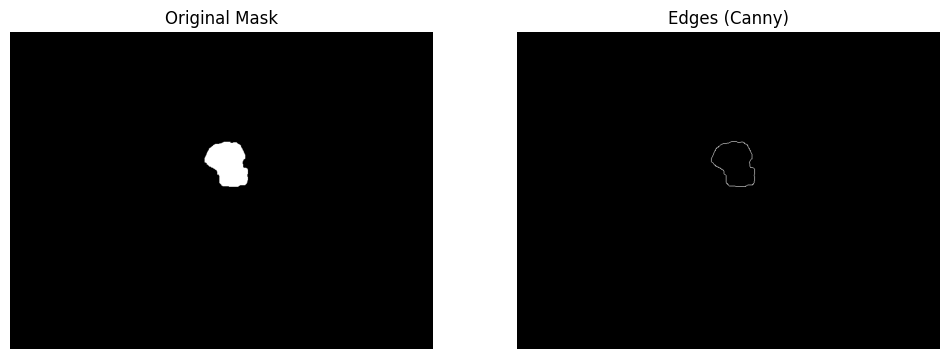

In [48]:
import torch
import torch.nn.functional as F
import matplotlib.pyplot as plt
import numpy as np
import cv2

def calculate_perimeter(mask):
    # Ensure the mask is a binary mask (0 and 1)
    mask = (mask > 0).float().cpu().numpy()

    # Convert binary mask to uint8 (required by Canny edge detector)
    mask_uint8 = (mask * 255).astype(np.uint8)

    # Apply Canny edge detector
    edges = cv2.Canny(mask_uint8, 100, 200)  # Adjust thresholds as needed

    # Count non-zero edge pixels to get the perimeter
    perimeter = np.sum(edges > 0)

    return perimeter, mask, edges

def plot_images(mask, edges):
    fig, ax = plt.subplots(1, 2, figsize=(12, 6))

    ax[0].imshow(mask, cmap='gray')
    ax[0].set_title('Original Mask')
    ax[0].axis('off')

    ax[1].imshow(edges, cmap='gray')
    ax[1].set_title('Edges (Canny)')
    ax[1].axis('off')

    plt.show()

# Example usage
if __name__ == "__main__":
    # Example binary mask (for visualization purposes)
    example_mask = train_dataset[7][0][3].squeeze()
    #example_mask = mask2
    perimeter, mask, edges = calculate_perimeter(example_mask)

    print(f"Calculated Perimeter: {perimeter}")

    plot_images(mask, edges)


Grain Size and Shape: Measuring the area, perimeter, and roundness of the grains, which are key diagnostic criteria for differentiating between actinomycetoma and eumycetoma.

In [49]:
import torch
import numpy as np
import cv2
from skimage.feature import graycomatrix, graycoprops, local_binary_pattern
from skimage.measure import regionprops, label
from scipy.ndimage import gaussian_filter
from skimage.color import rgb2gray
from skimage.filters import sobel
from scipy.stats import skew, kurtosis
from scipy.ndimage import gaussian_filter
from sklearn.preprocessing import MinMaxScaler


def summarise_histogram(histogram):
    # Compute basic statistics
    mean = np.mean(histogram)
    variance = np.var(histogram)
    skewness = skew(histogram)
    kurt = kurtosis(histogram)

    # Combine statistics into a summary vector
    summary_vector = np.array([mean, variance, skewness, kurt])
    return summary_vector

# Extract texture features using GLCM
def extract_glcm_features(image):
    glcm = graycomatrix(image, distances=[1], angles=[0], levels=256, symmetric=True, normed=True)
    contrast = graycoprops(glcm, 'contrast')[0, 0]
    homogeneity = graycoprops(glcm, 'homogeneity')[0, 0]
    energy = graycoprops(glcm, 'energy')[0, 0]
    return np.array([contrast, homogeneity, energy])

# Extract Local Binary Patterns (LBP) features
def extract_lbp_features(image):
    radius = 1
    n_points = 8 * radius
    lbp = local_binary_pattern(image, n_points, radius, method="uniform")
    lbp_hist, _ = np.histogram(lbp, bins=np.arange(0, n_points + 3), range=(0, n_points + 2))
    lbp_hist = lbp_hist.astype("float")
    lbp_hist /= lbp_hist.sum()  # Normalize histogram
    summary_lbp_hist = summarise_histogram(lbp_hist)
    return summary_lbp_hist

# Extract morphological features from segmentation mask
def extract_morphological_features(mask):
    labeled_mask = label(mask)
    regions = regionprops(labeled_mask)
    if len(regions) == 0:
        return 0, 0, 0, 0
        #return {'area': 0, 'perimeter': 0, 'eccentricity': 0, 'solidity': 0}

    # Taking properties of the first detected region
    region = regions[0]
    area = region.area
    perimeter = region.perimeter
    eccentricity = region.eccentricity
    solidity = region.solidity
    return np.array([area, perimeter, eccentricity, solidity])

# Extract color features
def extract_colour_features(image):
    mean = np.mean(image, axis=(0, 1))
    variance = np.var(image, axis=(0, 1))
    skewness = np.mean((image - mean) ** 3, axis=(0, 1)) / variance ** (3/2)
    colour_features = (mean, variance, skewness)
    colour_features = np.concatenate(colour_features)
    
    return colour_features

# Edge features using Sobel
def extract_edge_features(image):
    edges = sobel(image)
    print(edges)
    edge_hist = np.histogram(edges, bins=256)[0]
    summary_edge_hist = summarise_histogram(edge_hist)
    edge_density = np.sum(edges) / (image.shape[0] * image.shape[1])
    edge_features = np.concatenate([summary_edge_hist, np.array([edge_density])])
    return edge_features


# Calculate Dice score using the formula
def calculate_border_irregualirty(mask):
    mask = mask.astype(np.float32)
    # Apply Gaussian smoothing with a specified sigma
    sigma = 12.0
    smoothed_mask = gaussian_filter(mask, sigma=sigma)
    binary_smoothed_mask = (smoothed_mask >= 0.5).astype(np.uint8)
    intersection = np.sum(mask * binary_smoothed_mask)
    dice = (2 * intersection) / (np.sum(mask) + np.sum(binary_smoothed_mask))
    return np.array([dice])


def calculate_perimeter(mask):
    # Ensure the mask is a binary mask (0 and 1)
    mask = (mask > 0)

    # Convert binary mask to uint8 (required by Canny edge detector)
    mask_uint8 = (mask * 255).astype(np.uint8)

    # Apply Canny edge detector
    edges = cv2.Canny(mask_uint8, 100, 200)  # Adjust thresholds as needed

    # Count non-zero edge pixels to get the perimeter
    perimeter = np.sum(edges > 0)

    return perimeter

def calculate_area(mask):
    # Simply count the number of pixels within the mask (where mask is 1)
    area = mask.sum()
    return area.item()

def calculate_border_metrics(mask):
    perimeter = calculate_perimeter(mask)
    area = calculate_area(mask)
    print(perimeter, area)
    print(mask.dtype)

    # Compute circularity and border irregularity index 
    circularity = (4 * torch.pi * area) / (perimeter ** 2)

    BII = perimeter / np.sqrt(4 * np.pi * area)
    return np.array([circularity, BII])



def extract_features(image_path, mask_path):
    image_np = np.asarray(Image.open(image_path))
    segmentation_mask = np.asarray(Image.open(mask_path))

    gray_image = cv2.cvtColor((image_np * 255).astype(np.uint8), cv2.COLOR_RGB2GRAY)
    masked_image = cv2.bitwise_and(gray_image, gray_image, mask=segmentation_mask.astype(np.uint8))

    texture_features = extract_glcm_features(masked_image)
    lbp_features = extract_lbp_features(masked_image)
    morphological_features = extract_morphological_features(segmentation_mask)
    colour_features = extract_colour_features(image_np)
    edge_features = extract_edge_features(masked_image)
    border_irregularity = calculate_border_irregualirty(segmentation_mask)
    border_metrics = calculate_border_metrics(segmentation_mask)

    feature_vector = np.concatenate([
        texture_features,
        lbp_features,
        morphological_features,
        colour_features,
        edge_features,
        border_irregularity,
        border_metrics
    ])

    return feature_vector

first_time = False
if first_time:
    features_list = []
    for image_path, mask_path in train_paths:
        feature_vector = extract_features(image_path, mask_path)
        features_list.append(feature_vector)
    
    
    hand_crafted_features_df = pd.DataFrame(features_list, columns=[
        'contrast', 'homogeneity', 'energy', 'lbp1', 'lbp2', 'lbp3', 'lbp4',
        'area', 'perimeter', 'eccentricity', 'solidity', 'mean_R', 'mean_G', 'mean_B',
        'variance_R', 'variance_G', 'variance_B', 'skewness_R', 'skewness_G', 'skewness_B',
        'edge_density', 'edge_hist_0', 'edge_hist_1', 'edge_hist_2', 'edge_hist_3',
        'border_irregularity', 'circularity', 'BII'
    ])
    
    # Normalize features
    scaler = MinMaxScaler()
    df_normalised = pd.DataFrame(scaler.fit_transform(hand_crafted_features_df), columns=hand_crafted_features_df.columns)
    
    # Save to CSV
    df_normalised.to_csv('features_normalised.csv', index=False)
    
    print("Normalised features saved to 'features_normalised.csv'")
    
    
    val_features_list = []
    for image_path, mask_path in val_paths:
        feature_vector = extract_features(image_path, mask_path)
        val_features_list.append(feature_vector)
    
    val_hand_crafted_features_df = pd.DataFrame(val_features_list, columns=[
        'contrast', 'homogeneity', 'energy', 'lbp1', 'lbp2', 'lbp3', 'lbp4',
        'area', 'perimeter', 'eccentricity', 'solidity', 'mean_R', 'mean_G', 'mean_B',
        'variance_R', 'variance_G', 'variance_B', 'skewness_R', 'skewness_G', 'skewness_B',
        'edge_density', 'edge_hist_0', 'edge_hist_1', 'edge_hist_2', 'edge_hist_3',
        'border_irregularity', 'circularity', 'BII'
    ])
    
    # To normalize test data, use the same scaler
    def normalise_test_features(test_features, scaler):
        return pd.DataFrame(scaler.transform(test_features), columns=val_hand_crafted_features_df.columns)
    
    # Normalize test data
    df_test_normalised = normalise_test_features(val_hand_crafted_features_df, scaler)
    
    # # Save normalized test data to CSV
    df_test_normalised.to_csv('test_features_normalised.csv', index=False)


In [50]:
feature_vector = extract_features(val_paths[38][0], val_paths[38][1])
feature_vector

[[0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 ...
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]]
659 10706
uint8


array([ 6.72406466e+01,  9.77827702e-01,  9.77163146e-01,  1.00000000e-01,
        8.59919521e-02,  2.66663980e+00,  5.11102742e+00,  1.07060000e+04,
        7.24901587e+02,  7.62759521e-01,  6.96098830e-01,  2.07300975e+02,
        1.33848135e+02,  1.61799106e+02,  2.23835798e+03,  3.26024656e+03,
        2.36807839e+03, -9.56391129e-01,  1.16936614e-01, -4.09981411e-02,
        1.87500000e+03,  8.53743980e+08,  1.59060580e+01,  2.51003098e+02,
        4.46048402e-03,  9.04085856e-01,  3.09789201e-01,  1.79666399e+00])

In [24]:
feature_vector = extract_features(train_paths[39][0], train_paths[39][1])
feature_vector

array([ 5.14480267e+01,  9.69719200e-01,  9.67622156e-01,  1.00000000e-01,
        8.43235054e-02,  2.66658202e+00,  5.11084753e+00,  1.53420000e+04,
        6.02943218e+02,  8.18310990e-01,  8.51576377e-01,  2.01625171e+02,
        1.12601067e+02,  1.05957652e+02,  2.40247522e+03,  4.02111795e+03,
        2.55911465e+03, -1.00653713e+00,  6.77112061e-01,  6.22203354e-01,
        1.87500000e+03,  8.37390341e+08,  1.59057877e+01,  2.50997385e+02,
        3.55132826e-03,  9.64031634e-01,  5.69175075e-01,  1.32549186e+00])

In [10]:
hand_crafted_features_val_df = pd.read_csv('test_features_normalised.csv')
hand_crafted_features_val_df


,contrast,homogeneity,energy,lbp1,lbp2,lbp3,lbp4,area,perimeter,eccentricity,...,skewness_G,skewness_B,edge_density,edge_hist_0,edge_hist_1,edge_hist_2,edge_hist_3,border_irregularity,circularity,BII
0,0.027544,0.972230,0.969427,0.000000e+00,0.948965,0.999891,0.999892,0.025150,0.062326,0.523057,...,0.785057,0.832838,0.0,0.948783,0.999897,0.999897,0.033940,0.931076,0.198092,0.220782
1,0.017352,0.979750,0.977833,0.000000e+00,0.963141,0.999971,0.999972,0.021969,0.062015,0.915151,...,0.662299,0.709264,0.0,0.962975,0.999941,0.999941,0.022254,0.958477,0.338929,0.131271
2,0.093329,0.881848,0.875016,1.387779e-17,0.801108,0.999042,0.999046,0.105305,0.218872,0.952072,...,0.465971,0.504562,0.0,0.801175,0.998370,0.998364,0.125927,0.959366,0.095549,0.368072
3,0.078799,0.906802,0.900388,1.387779e-17,0.838405,0.998974,0.998977,0.026508,0.064811,0.696796,...,0.607273,0.642856,0.0,0.840149,0.998998,0.998994,0.099933,0.967551,0.132762,0.298326
4,0.004126,0.998288,0.998166,1.387779e-17,0.996958,1.000000,1.000000,0.000676,0.007125,0.848586,...,0.725866,0.777251,0.0,0.996510,1.000000,1.000000,0.003974,0.000000,0.233929,0.191239
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
86,0.004797,0.997708,0.997606,1.387779e-17,0.995979,0.999999,0.999999,0.002327,0.016953,0.672415,...,0.480101,0.514112,0.0,0.995691,1.000000,1.000000,0.005456,0.527438,0.356222,0.123841
87,0.007790,0.994462,0.994268,1.387779e-17,0.990352,0.999996,0.999996,0.005610,0.028077,0.677106,...,0.358159,0.414414,0.0,0.990033,0.999999,0.999999,0.009772,0.827513,0.359022,0.122685
88,0.053324,0.942357,0.940292,1.387779e-17,0.902452,0.999843,0.999844,0.059310,0.090918,0.452869,...,0.592601,0.602832,0.0,0.903220,0.999789,0.999788,0.067292,0.984069,0.480539,0.082141
89,0.270159,0.621034,0.598988,0.000000e+00,0.436073,0.988323,0.988329,0.399826,0.334347,0.930123,...,0.528072,0.571076,0.0,0.446197,0.984267,0.984187,0.459726,0.989978,0.237112,0.188909


In [54]:
model = DenseNet169(spatial_dims=2,
                                 in_channels=3,
                                 out_channels=1,
                                 pretrained=True)
model
# find number of parameters
def count_parameters(model):
    return sum(p.numel() for p in model.parameters() if p.requires_grad)
count_parameters(model)
#(1, 3, 600, 800)
#(64, 1024)
model

DenseNet169(
  (features): Sequential(
    (conv0): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (norm0): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (relu0): ReLU(inplace=True)
    (pool0): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (denseblock1): _DenseBlock(
      (denselayer1): _DenseLayer(
        (layers): Sequential(
          (norm1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
          (relu1): ReLU(inplace=True)
          (conv1): Conv2d(64, 128, kernel_size=(1, 1), stride=(1, 1), bias=False)
          (norm2): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
          (relu2): ReLU(inplace=True)
          (conv2): Conv2d(128, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        )
      )
      (denselayer2): _DenseLayer(
        (layers): Sequential(
          (norm1): BatchN

In [5]:
class CustomDenseNet(nn.Module):
    def __init__(self, in_channels, num_handcrafted_features, num_classes=1):
        super(CustomDenseNet, self).__init__()

        # Load pre-trained DenseNet model
        self.model = DenseNet169(spatial_dims=2,
                                    in_channels=in_channels,
                                    out_channels=1,
                                    pretrained=True)


        # Remove the final classifier layer
        num_features = self.model.features[-1].num_features
        self.model.class_layers.out = nn.Identity()

        # New classifier combining DenseNet features and hand-crafted features
        self.fc1 = nn.Linear(num_features + num_handcrafted_features, 1024)
        self.fc2 = nn.Linear(1024, num_classes)

    def forward(self, x, handcrafted_features):
        # Extract features from DenseNet
        dense_features = self.model(x)

        # Concatenate DenseNet features with hand-crafted features
        combined_features = torch.cat((dense_features, handcrafted_features), dim=1)

        # Pass through the final classifier
        x = self.fc1(combined_features)
        x = nn.ReLU()(x)
        x = self.fc2(x)

        return x

In [6]:
def train_model(hyperparams):
    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
    
    # Get the image paths
    DATA_DIR = r"C:\Users\mm17b2k.DS\DataspellProjects\MICCAI\Mycetoma Dataset"
    train_paths = np.array(['.'.join(i.split('.')) for i in glob.glob(f'{DATA_DIR}/training_dataset/**/*')])
    val_paths = np.array(['.'.join(i.split('.')) for i in glob.glob(f'{DATA_DIR}/validation_dataset/**/*')])
    
    # remove any with mask in it
    train_img_paths = train_paths[[not 'mask' in i for i in train_paths]]
    val_img_paths = val_paths[[not 'mask' in i for i in val_paths]]

    num_epochs = 30 #config["num_epochs"]
    lr = hyperparams["lr"]
    batch_size = hyperparams["batch_size"]
    weight_decay = hyperparams["weight_decay"]
    mask_channel = hyperparams["mask_channel"]
    threshold = hyperparams["threshold"]

    if mask_channel:
        num_channels = 4
    else:
        num_channels = 3

    seg_path_type = hyperparams["seg_path"]
    seg_paths = ["binary postprocessed/corrected_masks_and_augmented_postproc",
                "logit output/corrected_masks_and_augmented",
                "multitask/binary postprocessed/multitask_postproc",
                "multitask/logit output/multitask"]
    seg_path_end = seg_paths[seg_path_type]
    
    train_seg_paths = np.array(['.'.join(i.split('.')) for i in glob.glob(f'{DATA_DIR}/{seg_path_end}_training/**/*')])
    val_seg_paths = np.array(['.'.join(i.split('.')) for i in glob.glob(f'{DATA_DIR}/{seg_path_end}_validation/**/*')])

    
    train_paths = format_file_paths(train_seg_paths, train_img_paths)
    val_paths = format_file_paths(val_seg_paths, val_img_paths)
    
    hand_crafted_features_df = pd.read_csv('features_normalised.csv')
    hand_crafted_features_val_df = pd.read_csv('test_features_normalised.csv')
    
    train_dataset = MycetomaDataset(train_paths, DATA_DIR, hand_crafted_features_df, mask_channel=mask_channel, transform=True)
    test_dataset = MycetomaDataset(val_paths, DATA_DIR, hand_crafted_features_val_df, mask_channel=mask_channel)
    # MAKE DATALOADER
    train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
    test_loader = DataLoader(test_dataset, batch_size=5, shuffle=False)
    
    # model = DenseNet169(
    #     spatial_dims=2,
    #     in_channels=num_channels,
    #     out_channels=1,
    #     pretrained=True)
    num_handcrafted_features = 28  # Update according to your features
    model = CustomDenseNet(in_channels=num_channels, num_handcrafted_features=num_handcrafted_features).to(device)
    model = model.to(device)    
    criterion = nn.BCEWithLogitsLoss()
    optimiser = torch.optim.Adam(model.parameters(), lr=lr, weight_decay=weight_decay)
    lr_scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimiser, mode='min', factor=0.5, patience=10, verbose=True,
                                                              threshold=0.01, threshold_mode='abs')
    
    train_losses, test_losses = [], []
    accumulation_steps = 3
    for epoch in range(num_epochs):
        # Training phase
        model.train()
        train_loss = 0
        all_train_labels = []
        all_train_preds = []
        steps = 0
        optimiser.zero_grad()
    
    
        for features, hand_crafted_features, labels in train_loader:
            features, labels = features.to(device), labels.to(device)
            hand_crafted_features = hand_crafted_features.to(device)
            steps += 1
            # Forward pass
            #optimizer.zero_grad()
            output = model(features, hand_crafted_features.float())  # Remove batch dimension
            output = output.squeeze(1)
            loss = criterion(output, labels.float())
            train_loss += loss.item()
    
            # # Backward pass and optimization
            # loss.backward()
            # optimizer.step()
            # Backward pass and optimization
            loss.backward()
            if steps % accumulation_steps == 1:
                optimiser.step()
                optimiser.zero_grad()
    
            # Apply threshold to determine predicted class
            #predicted_probs = F.softmax(output, dim=1)[:, 1]  # Probability of class 1 (positive)
            predicted_probs = torch.sigmoid(output)
            predicted_class = (predicted_probs >= threshold).long()
    
            # Store predictions and labels
            all_train_labels.extend(labels.cpu().numpy())
            all_train_preds.extend(predicted_class.cpu().numpy())
    
        optimiser.step()
        optimiser.zero_grad()
        lr_scheduler.step(train_loss/len(train_loader))
        print('Learning rate:', optimiser.param_groups[0]['lr'])
        train_accuracy = accuracy_score(all_train_labels, all_train_preds)
        train_auc = roc_auc_score(all_train_labels, all_train_preds)
        train_confusion_matrix = confusion_matrix(all_train_labels, all_train_preds)
        tn, fp, fn, tp = confusion_matrix(all_train_labels, all_train_preds).ravel()
        # Compute sensitivity (recall) and specificity
        sensitivity = tp / (tp + fn)
        specificity = tn / (tn + fp)
        mcc = ((tp*tn) - (fp*fn)) / np.sqrt((tp+fp)*(tp+fn)*(tn+fp)*(tn+fn))
        print(f'Epoch [{epoch+1}/{num_epochs}], Train Loss: {train_loss/len(train_loader):.4f}, Train Accuracy: {train_accuracy:.4f}, Train AUC: {train_auc:.4f}, Sensitivity: {sensitivity:.4f}, Specificity: {specificity:.4f}', f'MCC: {mcc:.4f}')
        print(f'Train Confusion Matrix:')
        print(train_confusion_matrix)
        train_losses.append(train_loss/len(train_loader))
    
        # Evaluation phase
        model.eval()
        test_loss = 0
        all_test_labels = []
        all_test_preds = []
        all_test_probs = []
        with torch.no_grad():
            for features, hand_crafted_features, labels in test_loader:
                features, labels = features.to(device), labels.to(device)
                hand_crafted_features = hand_crafted_features.to(device)
                output = model(features, hand_crafted_features.float())  # Remove batch dimension
                output = output.squeeze(1)
                loss = criterion(output, labels.float())
                print(loss)
                test_loss += loss.item()
    
                # Store predictions and labels
                #predicted_probs = F.softmax(output, dim=1)[:, 1]  # Probability of class 1 (positive)
                predicted_probs = torch.sigmoid(output)
                predicted_class = (predicted_probs >= threshold).long()
                all_test_labels.extend(labels.cpu().numpy())
                all_test_preds.extend(predicted_class.cpu().numpy())
                all_test_probs.extend(predicted_probs.cpu().numpy())

        #tune.report({"loss": test_loss / len(test_loader)})
        
    
        test_accuracy = accuracy_score(all_test_labels, all_test_preds)
        test_auc = roc_auc_score(all_test_labels, all_test_preds)
        test_confusion_matrix = confusion_matrix(all_test_labels, all_test_preds)
        tn, fp, fn, tp = confusion_matrix(all_test_labels, all_test_preds).ravel()
        # Compute sensitivity (recall) and specificity
        sensitivity = tp / (tp + fn)
        specificity = tn / (tn + fp)
        mcc = ((tp*tn) - (fp*fn)) / np.sqrt((tp+fp)*(tp+fn)*(tn+fp)*(tn+fn))
        print(f'Test Loss: {test_loss/len(test_loader):.4f}, Test Accuracy: {test_accuracy:.4f}, Test AUC: {test_auc:.4f}', f'Sensitivity: {sensitivity:.4f}, Specificity: {specificity:.4f}', f'MCC: {mcc:.4f}')
        print('Test Confusion Matrix:')
        print(test_confusion_matrix)
        test_losses.append(test_loss/len(test_loader))
    
        if epoch == num_epochs-1: #or epoch % 25 == 0 
            prob_true, prob_pred = calibration_curve(all_test_labels, all_test_probs, n_bins=10)
    
            plt.figure(figsize=(10, 5))
    
            # Plot calibration curve
            plt.plot(prob_pred, prob_true, marker='o', label='DenseNet121')
            plt.plot([0, 1], [0, 1], linestyle='--', label='Perfectly calibrated')
            plt.xlabel('Predicted probability')
            plt.ylabel('True probability')
            plt.title('Calibration Curve')
            plt.legend()
            plt.show()
    
            # Plot distribution of predicted probabilities
            plt.hist(prob_pred, bins=10, range=(0, 1), edgecolor='k', alpha=0.7)
            plt.xlabel('Predicted probability')
            plt.ylabel('Frequency')
            plt.title('Distribution of Predicted Probabilities')
    
            plt.tight_layout()
            plt.show()
    
            # Plot the roc curve
            fpr, tpr, _ = roc_curve(all_test_labels, all_test_probs)
            roc_auc = auc(fpr, tpr)
            plt.figure(figsize=(10, 5))
            plt.plot(fpr, tpr, color='darkorange', lw=2, label='ROC curve (area = %0.2f)' % roc_auc)
            plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
            plt.xlim([0.0, 1.0])
            plt.ylim([0.0, 1.05])
            plt.xlabel('False Positive Rate')
            plt.ylabel('True Positive Rate')
            plt.title('Receiver Operating Characteristic')
            plt.legend(loc="lower right")
            plt.show()
            
        if fp < 5 and fn < 5:
            torch.save(model.state_dict(), r"C:\Users\mm17b2k.DS\Downloads\classifier_model.pt")
            break
    #print(all_test_probs)
    #print(hyperparams)
    
    # fig, ax1 = plt.subplots()
    # plt.plot(train_losses, 'm', label = 'training loss')
    # plt.plot(test_losses, 'g', label = 'test loss')
    # plt.yscale("log")
    # plt.legend(loc='lower right')
    # plt.xlabel('epoch')
    # plt.ylabel('loss')
    # plt.title('Training and validation loss')
    # plt.show()
    # plt.close()
    torch.save(model.state_dict(), r"C:\Users\mm17b2k.DS\Downloads\classifier_model_end.pt")
    return {"loss": test_loss/len(test_loader)}



In [7]:
# Hyperparams - current best
# threshold = 0.5
# num_epochs = 30
# lr = 4e-3
# weight_decay = 1e-3
# batch_size = 16

In [9]:
train_model({
    "lr": 4e-4,
    "batch_size": 10,
    "weight_decay": 1e-3,
    "mask_channel": True,
    "threshold": 0.5,
    "seg_path": 2})

Learning rate: 0.0004
Epoch [1/30], Train Loss: 0.5551, Train Accuracy: 0.7049, Train AUC: 0.7053, Sensitivity: 0.6977, Specificity: 0.7128 MCC: 0.4100
Train Confusion Matrix:
[[201  81]
 [ 94 217]]
tensor(5.4232, device='cuda:0')
tensor(6.5548, device='cuda:0')
tensor(0.2579, device='cuda:0')
tensor(0.9231, device='cuda:0')
tensor(4.5910, device='cuda:0')
tensor(0.0770, device='cuda:0')
tensor(0.0927, device='cuda:0')
tensor(nan, device='cuda:0')
tensor(1.8835e-06, device='cuda:0')
tensor(0.0419, device='cuda:0')
tensor(0.6001, device='cuda:0')
tensor(0.7314, device='cuda:0')
tensor(0.4659, device='cuda:0')
tensor(0.1710, device='cuda:0')
tensor(0.1365, device='cuda:0')
tensor(0.1559, device='cuda:0')
tensor(0.1719, device='cuda:0')
tensor(0.3983, device='cuda:0')
tensor(0.0012, device='cuda:0')
Test Loss: nan, Test Accuracy: 0.7253, Test AUC: 0.7046 Sensitivity: 0.8302, Specificity: 0.5789 MCC: 0.4257
Test Confusion Matrix:
[[22 16]
 [ 9 44]]
Learning rate: 0.0004
Epoch [2/30], Train

KeyboardInterrupt: 

In [4]:
def error_analysis(probabilities_list, labels):
    # find elementwise average across probabilities
    avg_conf = np.mean(probabilities_list, axis=0)
    print('Average confidence:', avg_conf)
    for i, score in enumerate(avg_conf):
        if (score <= 0.5 and labels[i] == 1) or (score >= 0.5 and labels[i] == 0):
            print(f'Incorrect on average: Index: {i}, label {labels[i]}, Average Confidence: {score}, file: {val_paths[i][0]}')
        elif (0.25 <= score <= 0.75):
            print(f'Unconfident but correct: Index: {i}, label {labels[i]}, Average Confidence: {score}, file: {val_paths[i][0]}')
            
    correct_positive_indices_list, incorrect_positive_indices_list, correct_negative_indices_list, incorrect_negative_indices_list = [], [], [], []

    for i in range(len(probabilities_list)):
        probabilities = probabilities_list[i]
        predictions = np.array([1 if j >= 0.5 else 0 for j in probabilities])

        # Correct positive predictions
        correct_positive_indices = np.where((labels == 1) & (predictions == 1))[0]

        # Incorrect positive predictions
        incorrect_positive_indices = np.where((labels == 0) & (predictions == 1))[0]

        # Confidence of positive predictions
        positive_predictions_probabilities = probabilities[predictions == 1]

        # print('Positive')
        # print('Correct positive indices and confidence:', correct_positive_indices, probabilities[correct_positive_indices])
        # print('Incorrect positive indices and confidence:', incorrect_positive_indices, probabilities[incorrect_positive_indices])

        # Correct positive predictions
        correct_negative_indices = np.where((labels == 0) & (predictions == 0))[0]

        # Incorrect positive predictions
        incorrect_negative_indices = np.where((labels == 1) & (predictions == 0))[0]

        # Confidence of positive predictions
        negative_predictions_probabilities = probabilities[predictions == 0]

        # print('Negative')
        # print('Correct negative indices and confidence:', correct_negative_indices, probabilities[correct_negative_indices])
        # print('Incorrect negative indices and confidence:', incorrect_negative_indices, probabilities[incorrect_negative_indices])

        correct_positive_indices_list.extend(correct_positive_indices)
        incorrect_positive_indices_list.extend(incorrect_positive_indices)
        correct_negative_indices_list.extend(correct_negative_indices)
        incorrect_negative_indices_list.extend(incorrect_negative_indices)

    correct_positive_counter = Counter(correct_positive_indices_list)
    incorrect_positive_counter = Counter(incorrect_positive_indices_list)
    correct_negative_counter = Counter(correct_negative_indices_list)
    incorrect_negative_counter = Counter(incorrect_negative_indices_list)

    average_confidence = np.mean(probabilities_list, axis=0)

    fig, ax = plt.subplots(4, 1, figsize=(12, 16))
    # Correct Positive Predictions
    ax[0].bar(correct_positive_counter.keys(), correct_positive_counter.values(), color='green')
    ax[0].set_title('Frequency of Correct Positive (TP) Predictions Indices Over Multiple Runs')
    ax[0].set_xlabel('Index')
    ax[0].set_ylabel('Frequency')
    ax[0].set_xticks(list(correct_positive_counter.keys()))

    # Incorrect Negative Predictions
    ax[1].bar(incorrect_negative_counter.keys(), incorrect_negative_counter.values(), color='red')
    ax[1].set_title('Frequency of Incorrect Negative (FN) Predictions Indices Over Multiple Runs')
    ax[1].set_xlabel('Index')
    ax[1].set_ylabel('Frequency')
    ax[1].set_xticks(list(incorrect_negative_counter.keys()))

    # Incorrect Positive Predictions
    ax[2].bar(incorrect_positive_counter.keys(), incorrect_positive_counter.values(), color='red')
    ax[2].set_title('Frequency of Incorrect Positive (FP) Predictions Indices Over Multiple Runs')
    ax[2].set_xlabel('Index')
    ax[2].set_ylabel('Frequency')
    ax[2].set_xticks(list(incorrect_positive_counter.keys()))

    # Correct Negative Predictions
    ax[3].bar(correct_negative_counter.keys(), correct_negative_counter.values(), color='green')
    ax[3].set_title('Frequency of Correct Negative (TN) Predictions Indices Over Multiple Runs')
    ax[3].set_xlabel('Index')
    ax[3].set_ylabel('Frequency')
    ax[3].set_xticks(list(correct_negative_counter.keys()))
    plt.tight_layout()
    plt.show()

In [5]:
#1 DenseNet169 with ground truth masks
# Train Loss: 0.0508, Train Accuracy: 0.9899, Train AUC: 0.9902, Sensitivity: 0.9839, Specificity: 0.9965 MCC: 0.9798
# Train Confusion Matrix:
# [[281   1]
#  [  5 306]]
# Test Loss: 0.2441, Test Accuracy: 0.9231, Test AUC: 0.9302 Sensitivity: 0.8868, Specificity: 0.9737 MCC: 0.8500
# Test Confusion Matrix:
# [[37  1]
#  [ 6 47]]

# 2 DenseNet169 with logit masks
#Train Loss: 0.0680, Train Accuracy: 0.9815, Train AUC: 0.9812, Sensitivity: 0.9871, Specificity: 0.9752 MCC: 0.9628
# Train Confusion Matrix:
# [[275   7]
#  [  4 307]]
# Test Loss: 0.2390, Test Accuracy: 0.9121, Test AUC: 0.9059 Sensitivity: 0.9434, Specificity: 0.8684 MCC: 0.8188
# Test Confusion Matrix:
# [[33  5]
#  [ 3 50]]

# 3 DenseNet169 with multitask logit masks
# Train Loss: 0.0427, Train Accuracy: 0.9916, Train AUC: 0.9915, Sensitivity: 0.9936, Specificity: 0.9894 MCC: 0.9831
# Train Confusion Matrix:
# [[279   3]
#  [  2 309]]
# Test Loss: 0.2281, Test Accuracy: 0.9121, Test AUC: 0.9171 Sensitivity: 0.8868, Specificity: 0.9474 MCC: 0.8252
# Test Confusion Matrix:
# [[36  2]
#  [ 6 47]]

#4  DenseNet169 with multitask binary masks
# Train Loss: 0.0548, Train Accuracy: 0.9865, Train AUC: 0.9863, Sensitivity: 0.9904, Specificity: 0.9823 MCC: 0.9730
# Train Confusion Matrix:
# [[277   5]
#  [  3 308]]
# Test Loss: 0.2374, Test Accuracy: 0.9341, Test AUC: 0.9434 Sensitivity: 0.8868, Specificity: 1.0000 MCC: 0.8751
# Test Confusion Matrix:
# [[38  0]
#  [ 6 47]]

# 5 just image
# Train Loss: 0.0576, Train Accuracy: 0.9882, Train AUC: 0.9882, Sensitivity: 0.9871, Specificity: 0.9894 MCC: 0.9763
# Train Confusion Matrix:
# [[279   3]
#  [  4 307]]
# Test Loss: 0.1092, Test Accuracy: 0.9780, Test AUC: 0.9811 Sensitivity: 0.9623, Specificity: 1.0000 MCC: 0.9561
# Test Confusion Matrix:
# [[38  0]
#  [ 2 51]]

# 6 just image
# Train Loss: 0.0571, Train Accuracy: 0.9865, Train AUC: 0.9860, Sensitivity: 0.9968, Specificity: 0.9752 MCC: 0.9731
# Train Confusion Matrix:
# [[275   7]
#  [  1 310]]
# Test Loss: 0.1488, Test Accuracy: 0.9231, Test AUC: 0.9191 Sensitivity: 0.9434, Specificity: 0.8947 MCC: 0.8415
# Test Confusion Matrix:
# [[34  4]
#  [ 3 50]]

# 7 just image
# {'threshold': 0.5, 'output_dim': 1, 'num_epochs': 25, 'lr': 5e-05, 'weight_decay': 0.001}
# Train Loss: 0.0278, Train Accuracy: 0.9983, Train AUC: 0.9982, Sensitivity: 1.0000, Specificity: 0.9965 MCC: 0.9966
# Train Confusion Matrix:
# [[281   1]
#  [  0 311]]
# Test Loss: 0.0853, Test Accuracy: 0.9670, Test AUC: 0.9717 Sensitivity: 0.9434, Specificity: 1.0000 MCC: 0.9351
# Test Confusion Matrix:
# [[38  0]
#  [ 3 50]]

# just mask on its own 
# Test Accuracy: 0.6703, Test AUC: 0.6909 Sensitivity: 0.5660, Specificity: 0.8158 MCC: 0.3834

labels = np.array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1])
probabilities = np.array([[0.057648662, 0.13251266, 0.030323213, 0.7076175, 0.1488829, 0.0029133568, 0.15396164, 0.043485172, 0.0902537, 0.02347875, 0.002472421, 0.003776084, 8.873705e-05, 0.01065515, 0.0020218734, 6.2414874e-05, 0.00077229383, 0.0005571693, 0.009528492, 0.0001969956, 0.012106179, 0.0034497313, 0.005522224, 0.023738058, 0.0020154698, 0.0034760116, 0.0357441, 0.061825495, 0.015583384, 0.09482298, 0.0074583306, 0.010102802, 0.07852834, 0.02021635, 0.035857957, 0.032903638, 0.28978655, 0.1141601, 0.99657226, 0.7939388, 0.7347509, 0.207687, 0.065647274, 0.99797803, 0.9999989, 0.9998721, 0.99271774, 0.6501528, 0.98410195, 0.9992976, 0.96147853, 0.9360526, 0.91196895, 0.87814724, 0.8590348, 0.97082907, 0.55427253, 0.17866428, 0.0823494, 0.027796227, 0.99536276, 0.9879985, 0.9998109, 0.9348579, 0.78386325, 0.9999987, 0.9999379, 0.99997413, 0.9994698, 0.9999999, 0.9999584, 0.9999968, 0.9999887, 0.9999124, 1.0, 0.9999269, 0.99999845, 0.9999994, 0.8845936, 0.9017963, 0.95805544, 0.6485618, 0.9788052, 0.9907527, 0.6780219, 0.8542743, 0.77982974, 0.70782614, 0.9631464, 0.9998436, 0.46281025], # 1
[0.44018522, 0.34349346, 0.8576869, 0.9085308, 0.15639234, 0.9325719, 0.8153716, 0.72126496, 0.45829782, 0.14289816, 0.1594381, 0.017974354, 0.017204808, 0.079142705, 0.16327263, 0.014951811, 0.011670333, 0.0026264575, 0.01356365, 0.016888425, 0.08041812, 0.066002086, 0.05038229, 0.05038229, 0.049053255, 0.054270636, 0.07437491, 0.067341164, 0.054270636, 0.027923262, 0.0041075805, 0.079419, 0.0053619076, 0.0053619076, 0.034874033, 0.102741085, 0.08300638, 0.1353758, 0.95935774, 0.36945152, 0.999655, 0.9959073, 0.8250343, 0.999546, 0.99860173, 0.9980356, 0.99893194, 0.67454696, 0.9912676, 0.99942577, 0.9066518, 0.906097, 0.88286203, 0.9432116, 0.933127, 0.95662344, 0.68359345, 0.7519299, 0.60160434, 0.44652763, 0.99971, 0.9964217, 0.999356, 0.9418481, 0.9774574, 0.9997229, 0.9972211, 0.9904165, 0.99343127, 0.9985077, 0.9998472, 0.99980587, 0.9999801, 0.9999999, 0.9999999, 0.9999999, 0.99999976, 0.99999857, 0.796125, 0.43011743, 0.9376712, 0.6947446, 0.9891558, 0.99718875, 0.8513512, 0.93497, 0.64304125, 0.55093926, 0.9965454, 0.99981827, 0.6492564], # 2 
[0.015826805, 0.07309353, 0.030696075, 0.0049576187, 0.28685787, 0.2750905, 0.03968281, 0.759553, 0.060727462, 0.07857234, 0.007904834, 0.011884623, 0.00025188876, 0.00014870541, 0.00085912563, 0.0030077142, 0.0023761436, 0.00025349934, 0.010753048, 0.0015876876, 0.13420492, 0.32326797, 0.00780785, 0.00780785, 0.0022495738, 0.06791253, 0.0002937375, 0.0007397992, 0.06791253, 0.0008056459, 0.013437897, 0.0011961084, 0.002425761, 0.002425761, 0.0033400133, 0.0053911135, 0.0013700866, 0.6165112, 0.87312055, 0.4728476, 0.9998247, 0.9983841, 0.97383773, 0.99944407, 0.99994195, 0.9995677, 0.9568097, 0.7361591, 0.71860856, 0.99916315, 0.9029098, 0.9528623, 0.88440144, 0.9002828, 0.95874244, 0.87183535, 0.14464891, 0.47491103, 0.13261083, 0.2148327, 0.9927269, 0.5907132, 0.99854064, 0.95161176, 0.9504121, 0.9985417, 0.9987866, 0.99673104, 0.8782047, 0.9995202, 0.99980456, 0.9990483, 0.9994455, 0.9999907, 0.9999819, 0.9999819, 0.9999889, 0.9999914, 0.7979214, 0.9540534, 0.9831086, 0.93588024, 0.9673767, 0.99289024, 0.91958976, 0.89585704, 0.84134793, 0.9243081, 0.9880683, 0.99964917, 0.22156657], #3
[0.008535521, 0.040429838, 0.0013002328, 0.0029006412, 0.099630505, 0.005676224, 0.015113053, 0.05915319, 0.077868365, 0.018408217, 0.010920803, 0.011437823, 0.003192917, 0.0003163443, 0.0018702524, 0.0015455952, 0.020717641, 0.00022538623, 0.031040668, 0.008252196, 0.016045151, 0.010188192, 0.0069710137, 0.0069710137, 0.006670982, 0.0027516505, 0.008174712, 0.001099582, 0.0027516505, 0.008664685, 0.0026675595, 0.0019587872, 0.0021042007, 0.0021042007, 0.0038366658, 0.0011121633, 0.0001067919, 0.012161266, 0.986906, 0.45633018, 1.0, 1.0, 0.9998425, 1.0, 1.0, 0.99999833, 0.9869496, 0.023280093, 0.19532341, 0.9890021, 0.6230195, 0.98229593, 0.37799075, 0.92165846, 0.93812, 0.9941506, 0.4721434, 0.6783353, 0.8831638, 0.73913443, 0.9999714, 0.6267879, 0.9999975, 0.9674667, 0.8530862, 0.99999964, 0.9999937, 0.99998796, 0.99999297, 0.9999999, 1.0, 0.9999999, 0.9999995, 1.0, 1.0, 1.0, 1.0, 1.0, 0.9364626, 0.6906867, 0.98100203, 0.63807505, 0.9844967, 0.9964986, 0.94705105, 0.9068745, 0.8494458, 0.8452797, 0.97664136, 0.9999088, 0.12142306], #4
 [0.08833644, 0.1633069, 0.025506161, 0.0045498204, 0.021559672, 0.007455003, 0.018239005, 0.0023367219, 0.080203, 0.12379198, 0.0076961424, 0.006612611, 0.0012851965, 0.00021506361, 0.0074763414, 0.0038890496, 0.0030335188, 4.787776e-05, 0.008320192, 0.01583937, 0.09894133, 0.21821557, 5.5139782e-05, 5.5139782e-05, 0.044390604, 0.0008392312, 0.000108729226, 0.0007067763, 0.0008392312, 2.9599601e-05, 5.0143153e-05, 3.5101966e-05, 2.101268e-06, 2.101268e-06, 0.00021730353, 1.6873875e-05, 5.4045864e-07, 0.0009501681, 0.8990985, 0.82269245, 0.9815828, 0.97364503, 0.98873645, 0.9757304, 0.9881011, 0.97683185, 0.76442957, 0.9848683, 0.9912163, 0.9743009, 0.7471334, 0.7871165, 0.8191089, 0.75972515, 0.8448576, 0.7968252, 0.41108596, 0.2884309, 0.751458, 0.53302217, 0.999944, 0.953689, 0.9998572, 0.98886, 0.9797987, 0.99999976, 0.9999994, 1.0, 0.9999093, 0.9999994, 0.9999907, 0.9999975, 0.99999917, 1.0, 1.0, 1.0, 1.0, 1.0, 0.9245396, 0.5684722, 0.73782796, 0.94898605, 0.8799265, 0.9968876, 0.8158101, 0.958319, 0.89719164, 0.8986541, 0.91331047, 0.9632082, 0.62238467], #5
[0.5410697, 0.9635723, 0.09101596, 0.025810938, 0.1329012, 0.25460988, 0.19122653, 0.03277724, 0.030101227, 0.061826196, 0.010662682, 0.0297179, 0.0014596017, 0.00011124033, 0.0025107383, 0.004103334, 0.0022227627, 8.893985e-05, 0.012162554, 0.0019515742, 0.5647942, 0.59159184, 0.0008679404, 0.0008679404, 0.038758725, 0.0012299956, 0.0012363537, 0.0023217914, 0.0012299956, 0.00040102281, 0.0014645467, 0.0012004263, 8.436208e-05, 8.436208e-05, 0.0018652563, 0.00022335011, 2.9936678e-05, 0.00041136274, 0.91033906, 0.9054641, 0.99838495, 0.9994967, 0.9995517, 0.9992142, 0.99993694, 0.99528813, 0.8889745, 0.63720757, 0.9743066, 0.982434, 0.67467034, 0.7645924, 0.7123568, 0.7514132, 0.93466604, 0.8703946, 0.4497924, 0.366571, 0.748451, 0.6004479, 0.9997758, 0.94413954, 0.99805546, 0.9954397, 0.9747141, 0.99999964, 1.0, 1.0, 0.999881, 0.9999993, 0.9999846, 0.9999877, 0.9999999, 0.9999999, 0.9999999, 0.9999999, 1.0, 1.0, 0.9700754, 0.41099015, 0.89514023, 0.8790551, 0.9686384, 0.9969121, 0.9890531, 0.977616, 0.92049146, 0.91338795, 0.9723456, 0.99677974, 0.8406587], #6
[0.40011355, 0.03681427, 0.015130686, 0.013662592, 0.04261297, 0.01064131, 0.06937232, 0.008099831, 0.0018533823, 0.26047954, 0.003050914, 0.010877135, 0.00021711981, 2.026713e-05, 0.0007700942, 0.0030872212, 0.007001325, 9.2680944e-05, 0.006529842, 0.0022168297, 0.09433989, 0.05927431, 0.0069628223, 0.0069628223, 0.020522272, 0.00014754906, 0.00016768696, 0.00046992654, 0.00014754906, 5.1534276e-05, 3.8499e-05, 1.7650666e-05, 8.148881e-06, 8.148881e-06, 5.1295796e-05, 0.00011631985, 2.0187848e-05, 0.0012188293, 0.96294755, 0.83474565, 0.9994097, 0.971106, 0.7606563, 0.9924035, 0.9978321, 0.98850024, 0.9013579, 0.99995863, 0.99999785, 0.999928, 0.9609384, 0.9744878, 0.9908461, 0.99532396, 0.9992273, 0.9990382, 0.87288815, 0.2688335, 0.9875159, 0.9030145, 0.99985754, 0.99237, 0.9998901, 0.99962294, 0.9986162, 1.0, 1.0, 1.0, 0.99999976, 1.0, 0.99997485, 0.9999734, 0.99999535, 1.0, 1.0, 1.0, 1.0, 1.0, 0.9083636, 0.398549, 0.94322973, 0.2534013, 0.9799913, 0.99998665, 0.997618, 0.99811184, 0.7334117, 0.9442052, 0.9985637, 0.9969687, 0.7098364], #7          
        ])


Average confidence: [2.21673700e-01 2.50460423e-01 1.50237033e-01 2.38289987e-01
 1.26976780e-01 2.12708311e-01 1.86138137e-01 2.32381445e-01
 1.14186422e-01 1.01350740e-01 2.88779852e-02 1.31829329e-02
 3.38575269e-03 1.29442108e-02 2.55401508e-02 4.37816287e-03
 6.82771685e-03 5.56001561e-04 1.31283494e-02 6.70472544e-03
 1.42978541e-01 1.81712814e-01 1.12241829e-02 1.38264449e-02
 2.33801259e-02 1.86610863e-02 1.71571756e-02 1.92149335e-02
 2.03907109e-02 1.89569614e-02 4.17493664e-03 1.34185538e-02
 1.26449745e-02 4.31469022e-03 1.14346464e-02 2.03577919e-02
 5.34743534e-02 1.25826961e-01 9.41191666e-01 6.65067186e-01
 9.59086864e-01 8.78032304e-01 8.01900893e-01 9.94902314e-01
 9.97773246e-01 9.94013421e-01 9.27167279e-01 6.72310493e-01
 8.36403181e-01 9.91935931e-01 8.25257396e-01 9.00500647e-01
 7.97076424e-01 8.78537487e-01 9.23967883e-01 9.22813780e-01
 5.12632114e-01 4.29667987e-01 5.98164753e-01 4.94967937e-01
 9.98192629e-01 8.70302834e-01 9.99358257e-01 9.68529586e-01
 9.3

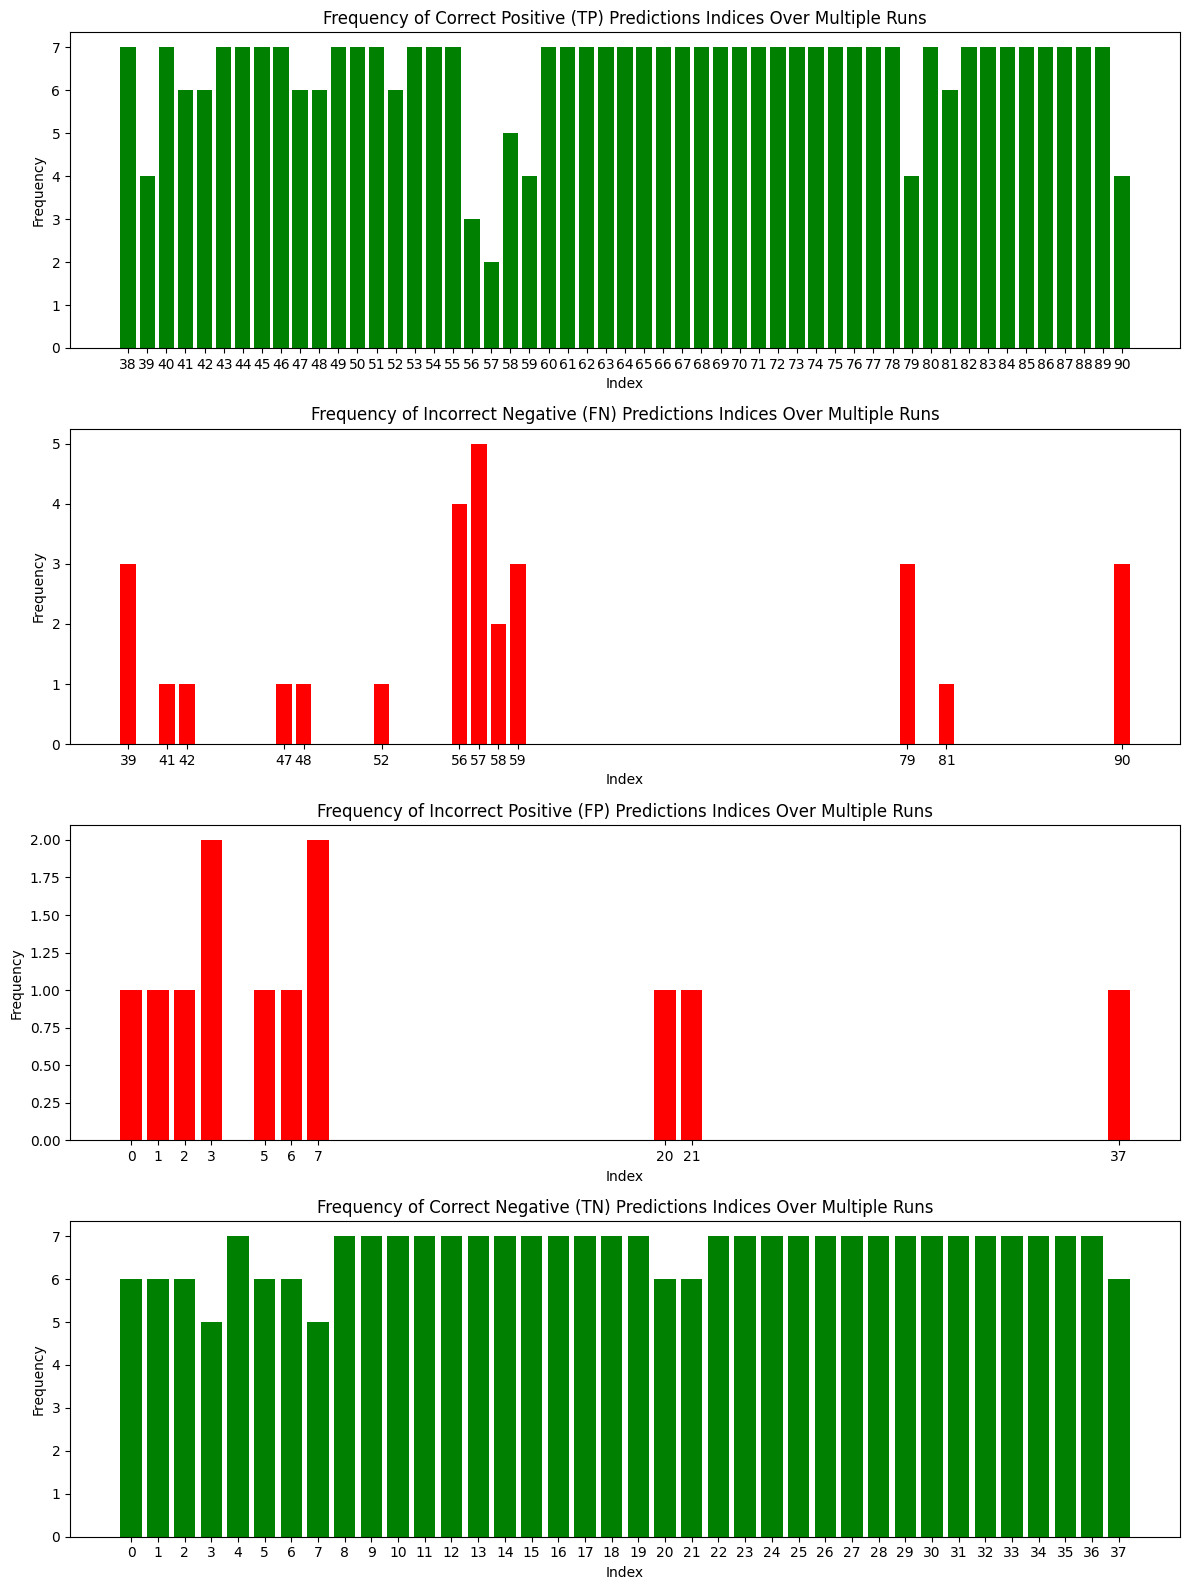

In [6]:
error_analysis(probabilities, labels)

In [ ]:
FPs = [BM12_4, BM12_8]
FNs = [FM34_4, FM34_2, FM34_3, FM104_2, FM9_3]



In [6]:
def custom_dirname_creator(trial):
    # Create a shorter directory name by using only the trial_id
    trial_id = trial.trial_id
    return f"trial_{trial_id}"

algo = HyperOptSearch()

tuner = tune.Tuner(  # ③
    train_model,
    tune_config=tune.TuneConfig(
        metric="loss",
        mode="min",
        search_alg=algo,
        num_samples=20,  # Number of trials to run
        trial_dirname_creator=custom_dirname_creator,
        max_concurrent_trials=1
    ),
    param_space=hyperparams,
)
results = tuner.fit()

(train_model pid=3284) C:\Users\mm17b2k.DS\AppData\Local\Temp\ipykernel_32056\2238971147.py:45: UserWarning: The given NumPy array is not writable, and PyTorch does not support non-writable tensors. This means writing to this tensor will result in undefined behavior. You may want to copy the array to protect its data or make it writable before converting it to a tensor. This type of warning will be suppressed for the rest of this program. (Triggered internally at ..\torch\csrc\utils\tensor_numpy.cpp:212.)
(train_model pid=22016) C:\Users\mm17b2k.DS\AppData\Local\Temp\ipykernel_32056\2238971147.py:45: UserWarning: The given NumPy array is not writable, and PyTorch does not support non-writable tensors. This means writing to this tensor will result in undefined behavior. You may want to copy the array to protect its data or make it writable before converting it to a tensor. This type of warning will be suppressed for the rest of this program. (Triggered internally at ..\torch\csrc\utils\

(train_model pid=3284) Learning rate: 4.035523266148395e-05
(train_model pid=3284) Epoch [1/50], Train Loss: 0.5984, Train Accuracy: 0.6847, Train AUC: 0.6693, Sensitivity: 0.9839, Specificity: 0.3546 MCC: 0.4429
(train_model pid=3284) Train Confusion Matrix:
(train_model pid=3284) [[100 182]
(train_model pid=3284)  [  5 306]]
(train_model pid=3284) Test Loss: 0.6045, Test Accuracy: 0.6154, Test AUC: 0.5655 Sensitivity: 0.8679, Specificity: 0.2632 MCC: 0.1659
(train_model pid=3284) Test Confusion Matrix:
(train_model pid=3284) [[10 28]
(train_model pid=3284)  [ 7 46]]
(train_model pid=22016) Learning rate: 2.9405610305424545e-05
(train_model pid=22016) Epoch [1/50], Train Loss: 0.5921, Train Accuracy: 0.7116, Train AUC: 0.7157, Sensitivity: 0.6334, Specificity: 0.7979 MCC: 0.4353
(train_model pid=22016) Train Confusion Matrix:
(train_model pid=22016) [[225  57]
(train_model pid=22016)  [114 197]]
(train_model pid=22016) Test Loss: 0.5864, Test Accuracy: 0.6703, Test AUC: 0.6500 Sensiti

TuneError: Traceback (most recent call last):
  File "C:\Users\mm17b2k\AppData\Local\anaconda3\envs\ben\Lib\site-packages\ray\tune\execution\tune_controller.py", line 1220, in _on_result
    on_result(trial, *args, **kwargs)
  File "C:\Users\mm17b2k\AppData\Local\anaconda3\envs\ben\Lib\site-packages\ray\tune\execution\tune_controller.py", line 1519, in _on_training_result
    self._process_trial_results(trial, result)
  File "C:\Users\mm17b2k\AppData\Local\anaconda3\envs\ben\Lib\site-packages\ray\tune\execution\tune_controller.py", line 1532, in _process_trial_results
    decision = self._process_trial_result(trial, result)
               ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "C:\Users\mm17b2k\AppData\Local\anaconda3\envs\ben\Lib\site-packages\ray\tune\execution\tune_controller.py", line 1569, in _process_trial_result
    self._validate_result_metrics(flat_result)
  File "C:\Users\mm17b2k\AppData\Local\anaconda3\envs\ben\Lib\site-packages\ray\tune\execution\tune_controller.py", line 1678, in _validate_result_metrics
    raise ValueError(
ValueError: Trial returned a result which did not include the specified metric(s) `loss` that `tune.TuneConfig()` expects. Make sure your calls to `tune.report()` include the metric, or set the TUNE_DISABLE_STRICT_METRIC_CHECKING environment variable to 1. Result: {'test_loss': 0.1622505125535195, 'timestamp': 1723767652, 'checkpoint_dir_name': None, 'done': False, 'training_iteration': 1, 'trial_id': '2b355a44', 'date': '2024-08-16_01-20-52', 'time_this_iter_s': 33601.60214924812, 'time_total_s': 33601.60214924812, 'pid': 3284, 'hostname': 'UOL-3LDFCX3', 'node_ip': '127.0.0.1', 'time_since_restore': 33601.60214924812, 'iterations_since_restore': 1, 'config/lr': 4.035523266148395e-05, 'config/batch_size': 16, 'config/weight_decay': 1.0159958517029868e-05, 'config/mask_channel': False, 'config/threshold': 0.4150213059158631, 'config/seg_path': 0}
